In [1]:
%matplotlib inline
import matplotlib.image as mpimg
import numpy as np
import matplotlib.pyplot as plt
import os,sys
from PIL import Image              #create image from array
from sklearn import linear_model   #logistic regression model
from datetime import datetime      #date for submission file
from scipy import ndimage, signal,stats  #image (ndarray) rotation and correlation #stats for mode
from sklearn.preprocessing import PolynomialFeatures # efficient polynomial augmentation
import cv2
from skimage import img_as_float
import shutil

#Personal libraries
from proj2_helpers import *
from mask_to_submission import *
from submission_to_mask import *

%load_ext autoreload
%autoreload 2

### 1) Loading the set of images

In [3]:
def LoadTrainingData(n_img, rootdir="Datasets/training/", printnames=False):
    """ Load the data from the root directory. (a total of n_img images) """

    image_dir = rootdir + "images/"
    files = os.listdir(image_dir)

    n = min(n_img, len(files)) # Load maximum 20 images
    print("Loading " + str(n) + " train images...")
    imgs = [load_image(image_dir + files[i]) for i in range(n)]

    gt_dir = rootdir + "groundtruth/"
    print("Loading " + str(n) + " groundtruth images...")
    gt_imgs = [load_image(gt_dir + files[i]) for i in range(n)]

    if (printnames):
        print("The loaded images are: ")
        for i in range(n):
            print("    - " + files[i])
    
    return imgs, gt_imgs

In [4]:
rootdir="Datasets/training/"
imagedir = rootdir + "images/"
files = os.listdir(imagedir)
#image_enhanced = cv2.equalizeHist(test_image)
#plt.imshow(test)
n=100
imgs_raw, gt_imgs = LoadTrainingData(n, rootdir)

Loading 100 train images...
Loading 100 groundtruth images...


Original image: the shape of image=(400, 400, 3), the data type=float32.


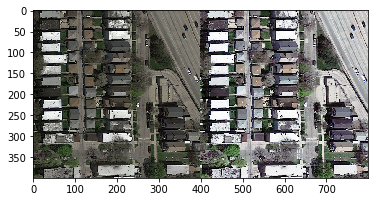

In [20]:
number = 25

print("Original image: the shape of image={s}, the data type={dt}.".format(
        s=imgs_raw[number].shape, dt=imgs_raw[number].dtype))

imgs_equalized = np.zeros((n,400,400,3));

for i in range(n):
    uint8 = img_float_to_uint8(imgs_raw[i])
    #uint8 = imgs_raw[i].astype(np.uint8);
    if (i==number): before = uint8;
    r,g,b = cv2.split(uint8)
    uint8_equalized = cv2.merge((cv2.equalizeHist(r), cv2.equalizeHist(g), cv2.equalizeHist(b)))
    if (i==number): after = uint8_equalized;
    imgs_equalized[i]= img_as_float(uint8_equalized);
    #imgs_equalized[i] = uint8_equalized.astype(np.float32)
    
show = concatenate_images(imgs_raw[number],imgs_equalized[number])
plt.imshow(show);


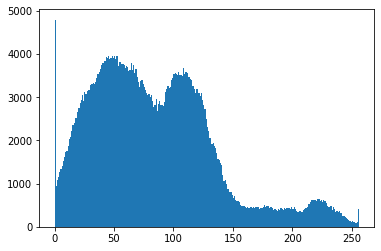

In [13]:
plt.hist(before.ravel(),256,[0,256]); 
plt.show()


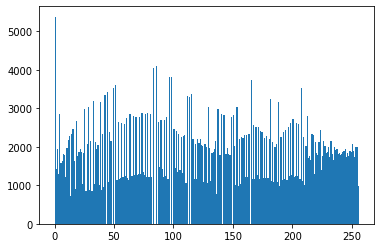

In [14]:
plt.hist(after.ravel(),256,[0,256]); 
plt.show()

### 2) Images analysis

In [21]:
def RoadColorAnalysis(imgs, gt_imgs, n, ifprint=True):
    """
        Analyses the color of the road (signal) and of the background. 
    """

    #Assign an array of 3 elements (1 for each color RGB) for each image (mean and std)
    mean_road_img = np.zeros((n,3))
    mean_notroad_img = np.zeros((n,3)) 
    std_road_img = np.zeros((n,3))

    for ind_im in range(n):

        #get current image and corresponding groundtruth
        img = imgs[ind_im]           
        gt = gt_imgs[ind_im] 

        #fill mean_road, a pixel is considered to be part of a road in the gt if its value is bigger than threshold th
        th_down = 0.31 #80/255
        th_up = 0.78   #200/255
        road = (gt > th_down)&(gt < th_up)
        not_road = (gt < th_down)|(gt > th_up)
        mean_road_img[ind_im,:] = img[road,:].mean(axis=0)
        std_road_img[ind_im,:] = img[road,:].std(axis=0)
        mean_notroad_img[ind_im,:] = img[not_road,:].mean(axis=0)
        

    #average over image
    mean_roads = mean_road_img.mean(axis=0)
    std_roads= mean_road_img.std(axis=0)    #not returned
    mean_notroads = mean_notroad_img.mean(axis=0)
    mean_of_std_roads = std_road_img.mean(axis=0)

    #print results
    print("The mean color of the roads are (RGB): ", mean_roads)
    print("The standard deviation of the mean color of the roads are (RGB): ", std_roads)
    print("The mean of the standard deviation of the color of the roads are (RGB): ", mean_of_std_roads)

    #if ifprint is true, plots ethe signals, the bacground and the average mean of the signal and background's colors
    if (ifprint):
        fig, axs = plt.subplots(n, 3, figsize=(12,n*5))
        for i in range(n):

            img_onlyroad = np.copy(imgs[i])
            img_onlyroad[(gt_imgs[i] < th_down)&(gt_imgs[i] > th_up),:]=np.array([1,1,1])

            img_notroad = np.copy(imgs[i])
            img_notroad[(gt_imgs[i] > th_down)&(gt_imgs[i] < th_up),:]=np.array([1,1,1])

            axs[i,0].imshow(img_onlyroad, cmap='Greys_r')
            axs[i,0].set_title("signal in " + files[i])

            axs[i,1].imshow(concatenate_images(mean_road_img[i,:].reshape(1,1,3),mean_notroad_img[i,:].reshape(1,1,3)))
            axs[i,1].set_title("Average color of the road (left) \n Average color of the rest (right)")
            axs[i,1].set_axis_off()

            axs[i,2].imshow(img_notroad, cmap='Greys_r')
            axs[i,2].set_title("background in " + files[i])
            
    return mean_roads, mean_notroads, std_roads

In [22]:
mean_road, mean_notroad, std_road = RoadColorAnalysis(imgs_raw, gt_imgs, n, ifprint=False)

The mean color of the roads are (RGB):  [0.32600472 0.32226133 0.28203546]
The standard deviation of the mean color of the roads are (RGB):  [0.04818185 0.04370083 0.04697165]
The mean of the standard deviation of the color of the roads are (RGB):  [0.15838502 0.14947172 0.14529957]


### 3) Chanel (features) augmentation

In [23]:
def ChanelAugmentation(imgs):
    """ Add three chanels to the original images. (Grey level, vertical edge and horizontal edges)"""
    
 
    new_imgs = []
    #Sobel filters masks
    V_kernel = np.array([[-1,0,1],[-2,0,2],[-1,0,1]])
    H_kernel = np.array([[-1,-2,-1],[0,0,0],[1,2,1]])
    
    # Performing the correlation on each image
    for i, img in enumerate(imgs):
        Grey_level = img.mean(axis=2)
        V_Edges = signal.correlate2d(Grey_level, V_kernel, mode='same', boundary='symm')
        H_Edges = signal.correlate2d(Grey_level, H_kernel, mode='same', boundary='symm')
        new_imgs += [np.dstack((img, Grey_level, V_Edges, H_Edges))]
    
    return new_imgs

In [24]:
# Add three chanels to the original images. (Grey level, vertical edges and horizontal edges)
print("The images had originally ",imgs_equalized[0].shape[2], "channels")
imgs = ChanelAugmentation(imgs_equalized)
print("The images have now ", imgs[0].shape[2], "channels")

The images had originally  3 channels
The images have now  6 channels


### 3) Data augmentation

In [25]:
# The augmented data will present itself as follows: 
# [original img, 90° rotation, 180° rotation, 270° rotation, 
#  symmetry original img, sym 90° rot img, sym 180° rot img, sym 270° img]

def DataAugmentation(imgs, gt_imgs, angles, sym=True):
    """
    Augments the data by rotating the image with the angles given in the list <angles>.
    If <sym> is true, it also augments the the data with the images obtained by performing a
    y axis symmetry.
    
    The augmented data will present itself as follows: 
        
        [angles[1] rotations, ..., angles[end] rotations,
        Y axis symmetry of the angles[1] rotations, ..., Y axis symmetry of the angles[end] rotations]
 
    """
    n = len(imgs)
    
    # Creating the augmented version of the images.
    aug_imgs = []
    aug_gt_imgs = []
    
    # Rotating the images and adding them to the augmented data list
    for theta in angles:
        print("Augmenting the data with the images rotated by", theta , "deg.")
        aug_imgs += [BuildRotatedImage(imgs[i], theta) for i in range(n)]
        aug_gt_imgs += [BuildRotatedImage(gt_imgs[i], theta) for i in range(n)]  
        
    # Y symmetry of the images and adding them to the augmented dat list
    if (sym):
        print("Augmenting the data with the symmetries")
        n_tmp = len(aug_imgs)
        aug_imgs += [np.flip(aug_imgs[i],1) for i in range(n_tmp)]
        aug_gt_imgs += [np.flip(aug_gt_imgs[i],1) for i in range(n_tmp)]
        
    return aug_imgs, aug_gt_imgs


def PlotAugmentedData(imgs, gt_imgs, id_img=0):
    """ 
    Plot one image (id_img) and its corresponding rotations and symmetries.
    The angles for the rotations are [0, 45, 90, 135, 180, 225, 270, 315].
    """
    
    aug_imgs, aug_gt_imgs = DataAugmentation([imgs[id_img]], [gt_imgs[id_img]], [0, 45, 90, 135, 180, 225, 270, 315], sym=True)
    
    nimgs = int(len(aug_imgs)/16)

    titles = ["Original image", 
              "Rotated image (45°)", 
              "Rotated image (90°)",
              "Rotated image (135°)", 
              "Rotated image (180°)", 
              "Rotated image (225°)", 
              "Rotated image (270°)",
              "Rotated image (315°)", 
              "Y axis sym. of the \n original version",
              "Y axis sym. of the \n rotated image (45°)", 
              "Y axis sym. of the \n rotated image (90°)",
              "Y axis sym. of the \n rotated image (135°)", 
              "Y axis sym. of the \n rotated image (180°)", 
              "Y axis sym. of the \n rotated image (225°)",
             "Y axis sym. of the \n rotated image (270°)",
             "Y axis sym. of the \n rotated image (305°)"]
    
    fig_augData, axs = plt.subplots(4, 4, figsize=(16, 12))
    
    for i in range(16):
        print
        axs[int(i/4), (i % 4)].imshow(concatenate_images(aug_imgs[i], aug_gt_imgs[i]), cmap='Greys_r')
        axs[int(i/4), (i % 4)].set_title(files[id_img] + "\n" + titles[i])  
            
def ChanelAugmentation(imgs):
    
    raise NotImplementedError
    
def BuildExtendedImage(img):
    """ Create a 3x3 grid of the imput image by mirroring it at the boundaries"""

    top_and_lower_row = np.concatenate((np.flip(np.flip(img,0),1), np.flip(img,0), np.flip(np.flip(img,0),1)), axis=1)
    mid_row = np.concatenate((np.flip(img,1), img, np.flip(img,1)), 1)
    
    ext_img = np.concatenate((top_and_lower_row, mid_row, top_and_lower_row), 0)
       
    return ext_img

def BuildRotatedImage(img, degree):
    """ Return the same image rataded by <degree> degrees. The corners are filled using mirrored boundaries. """
    
    # Improving performance using existing functions for specific angles
    if (degree==0):
        return img
    elif (degree==90):
        return np.rot90(img)
    elif (degree==180):
        return np.rot90(np.rot90(img))
    elif (degree==270):
        return np.rot90(np.rot90(np.rot90(img)))
    else:
        h = img.shape[0]
        w = img.shape[1]

        # Extend and rotate the image
        ext_img = BuildExtendedImage(img)
        rot_img = ndimage.rotate(ext_img, degree, reshape=False)

        # Taking care of nummerical accuracies (not sure where they come from)

        rot_img[rot_img<0] = 0.0
        rot_img[rot_img>1] = 1.0

        # Crop the image
        if (len(img.shape) > 2):
            rot_img = rot_img[h:2*h, w:2*w, :]
        else:
            rot_img = rot_img[h:2*h, w:2*w]
        
        return rot_img

In [26]:
# Visualisation of the totally augmented data for the id_img-th image
#PlotAugmentedData(imgs_raw, gt_imgs,id_img=1)

In [27]:
# Augmenting the data
#angles = [0, 45, 90, 135, 180, 225, 270, 315]
angles = [0, 45]
aug_imgs, aug_gt_imgs = DataAugmentation(imgs, gt_imgs, angles, False)

# For the logistic regression, no need to augment the data. However, for convenience later on, we name the data aug_XXX.
#aug_imgs, aug_gt_imgs = np.copy(imgs), np.copy(gt_imgs)

Augmenting the data with the images rotated by 0 deg.
Augmenting the data with the images rotated by 45 deg.


### 4) Extract patches

In [28]:
def ExtractPatch(imgs, gt_imgs, patch_size=16):
    """ Extract patches of size patch_size from the input images.  """ 
    n = len(imgs)
    
    img_patches = [img_crop(imgs[i], patch_size, patch_size) for i in range(n)]
    gt_patches = [img_crop(gt_imgs[i], patch_size, patch_size) for i in range(n)]


    # Linearize list of patches
    img_patches = np.asarray([img_patches[i][j] for i in range(len(img_patches)) for j in range(len(img_patches[i]))])
    gt_patches =  np.asarray([gt_patches[i][j] for i in range(len(gt_patches)) for j in range(len(gt_patches[i]))])

    return img_patches, gt_patches

In [29]:
patch_size=16

img_patches, gt_patches = ExtractPatch(aug_imgs, aug_gt_imgs, patch_size)

print("img_patches has size ", img_patches.shape)
print("gt_patches has size ", gt_patches.shape)

img_patches has size  (125000, 16, 16, 6)
gt_patches has size  (125000, 16, 16)


### 5) Extract features

In [ ]:
# Extract 6-dimensional features consisting of average RGB color as well as variance
def extract_features(img):
    feat_m = np.mean(img, axis=(0,1))
    feat_v = np.var(img, axis=(0,1))   
    #feat_p = stats.mode(img, axis=(0,1))
    features = np.append(feat_m, feat_v)
    return features

# Extract 2-dimensional features consisting of average gray color as well as variance
def extract_features_2d(img):
    th_down = 0.31 #80/255
    th_up = 0.78   #200/255
    road = 0;
    feat_m = np.mean(img)
    if ((feat_m > th_down)&(feat_m < th_up)): 
        road = 1;
    feat_v = np.var(img)
    feat_p = stats.mode(img)
    features = np.append(feat_m, feat_v,feat_p,road)
    return features

# Extract features for a given image
def extract_img_features(filename):
    img_raw = load_image(filename)
    [img] = ChanelAugmentation([img_raw])
    img_patches = img_crop(img, patch_size, patch_size)
    X = np.asarray([extract_features(img_patches[i]) for i in range(len(img_patches))])
    return X, img, img_raw

def build_poly(X, degree, interaction_only=False):
    """polynomial basis functions for input data X, for j=0 up to j=degree. """
    poly = PolynomialFeatures(degree, interaction_only)
    return poly.fit_transform(X)

def value_to_class(v, foreground_threshold):
    df = np.sum(v)
    if df > foreground_threshold:
        return 1
    else:
        return 0
    
def PrintFeatureStatistics(X, Y):
    print('There are ' + str(X.shape[0]) + ' data points')
    print('Each data point has ' + str(X.shape[1]) + " features")
    #print('Number of classes = ' + str(np.max(Y)))  #TODO: fix, length(unique(Y)) 
    print('Number of classes = ' + str(len(np.unique(Y))))

    Y0 = [i for i, j in enumerate(Y) if j == 0]
    Y1 = [i for i, j in enumerate(Y) if j == 1]
    print('Class 0 (background): ' + str(len(Y0)) + ' samples')
    print('Class 1 (signal): ' + str(len(Y1)) + ' samples')

def NormalizeFeatures(X):
    """Normalize X which must have shape (num_data_points,num_features)"""
    m = np.mean(X,axis=0)
    s = np.std(X,axis=0)
    
    return (X-m)/s

[autoreload of six failed: Traceback (most recent call last):
  File "C:\Users\emili\Anaconda3\lib\site-packages\IPython\extensions\autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "C:\Users\emili\Anaconda3\lib\site-packages\IPython\extensions\autoreload.py", line 450, in superreload
    update_generic(old_obj, new_obj)
  File "C:\Users\emili\Anaconda3\lib\site-packages\IPython\extensions\autoreload.py", line 387, in update_generic
    update(a, b)
  File "C:\Users\emili\Anaconda3\lib\site-packages\IPython\extensions\autoreload.py", line 357, in update_class
    update_instances(old, new)
  File "C:\Users\emili\Anaconda3\lib\site-packages\IPython\extensions\autoreload.py", line 317, in update_instances
    update_instances(old, new, obj, visited)
  File "C:\Users\emili\Anaconda3\lib\site-packages\IPython\extensions\autoreload.py", line 317, in update_instances
    update_instances(old, new, obj, visited)
  File "C:\Users\emili\Anaconda3\lib\site-pa

In [ ]:
# Compute features for each image patch
foreground_threshold = 0.25 # percentage of pixels > 1 required to assign a foreground label to a patch

X = np.asarray([extract_features(img_patches[i]) for i in range(len(img_patches))])
Y = np.asarray([value_to_class(np.mean(gt_patches[i]), foreground_threshold) for i in range(len(gt_patches))])

# Print feature statistics
PrintFeatureStatistics(X, Y)

###  K-means color clustering

In [48]:
def initialize_clusters(data, k):
    """initialize the k cluster centers (the means).
    input:
        data: original data with shape (num_sample, num_feature).
        k: predefined number of clusters for the k-means algorithm.
    output:
        a numpy array with shape (k, num_feature)
    """
    num_samples, num_feature = data.shape
    return data[np.random.choice(num_samples, k)]

def build_distance_matrix(data, mu):
    """build a distance matrix.
    return
        distance matrix:
            row of the matrix represents the data point,
            column of the matrix represents the k-th cluster.
    """
    distance_list = []
    num_cluster, _ = mu.shape
    for k_th in range(num_cluster):
        sum_squares = np.sum(np.square(data - mu[k_th, :]), axis=1)
        distance_list.append(sum_squares)
    return np.array(distance_list).T

def update_kmeans_parameters(data, mu_old):
    """update the parameter of kmeans
    return:
        losses: loss of each data point with shape (num_samples, 1)
        assignments: assignments vector z with shape (num_samples, 1)
        mu: mean vector mu with shape (k, num_features)
    """
    _, num_features = data.shape
    num_clusters, _ = mu_old.shape
    distance_matrix = build_distance_matrix(data, mu_old)
    losses = np.min(distance_matrix, axis=1)
    assignments = np.argmin(distance_matrix, axis=1)

    # update the mu
    mu = np.empty((num_clusters, num_features))
    for k_th in range(num_clusters):
        rows = np.where(assignments == k_th)
        mu[k_th, :] = np.mean(np.squeeze(data[rows, :]), axis=0)
    return losses, assignments, np.nan_to_num(mu)

def build_dir(dir):
    """build a new dir. if it exists, remove it and build a new one."""
    if os.path.exists(dir):
        shutil.rmtree(dir)
    os.makedirs(dir)
    
def plot_cluster(data, mu, colors, ax):
    """
    plot the cluster.

    Note that the dimension of the column vector `colors`
    should be the same as the number of clusters.
    """
    # build distance matrix.
    distance_matrix = build_distance_matrix(data, mu)
    # get the assignments for each point.
    assignments = np.argmin(distance_matrix, axis=1)
    for k_th in range(mu.shape[0]):
        rows, cols = np.where(assignments == k_th)
        data_of_kth_cluster = data[rows, :]
        ax.scatter(
            data_of_kth_cluster[:, 0],
            data_of_kth_cluster[:, 1],
            # works for clusters more than 3
            s=40, c=colors[k_th % len(colors)])
    ax.grid()
    ax.set_xlabel("x")
    ax.set_ylabel("y")


def plot(data, mu, mu_old, out_dir):
    """plot."""
    colors = ['red', 'blue', 'green']
    fig = plt.figure()
    ax1 = fig.add_subplot(1, 2, 1)
    plot_cluster(data, mu_old, colors, ax1)
    ax1.scatter(mu_old[:, 0], mu_old[:, 1],
                facecolors='y', edgecolors='y', s=80)

    ax2 = fig.add_subplot(1, 2, 2)
    plot_cluster(data, mu, colors, ax2)
    ax2.scatter(mu[:, 0], mu[:, 1],
                facecolors='y', edgecolors='y', s=80)

    # matplotlib.rc('xtick', labelsize=5)
    # matplotlib.rc('ytick', labelsize=5)

    plt.tight_layout()
    plt.savefig(out_dir)
    plt.show()
    plt.close()
    
def kmeans(data, k, max_iters, threshold):
    """run the k-means algorithm."""
    output_figure = "kmeans_figures/"
    # initialize the cluster.
    mu_old = initialize_clusters(data, k)
    # init some empty lists to store the result.
    loss_list = []

    # start the kmeans algorithm.
    for iteration in range(max_iters):
        # update z and mu
        losses, assignments, mu = update_kmeans_parameters(data, mu_old)
        print(assignments.shape)
        # calculate the average loss over all points
        average_loss = np.mean(losses)
        loss_list.append(average_loss)
        print("The current iteration of k-means is: {i}, \
               the average loss is {l}.".format(i=iteration, l=average_loss))
        # check converge
        if iteration > 0 and np.abs(loss_list[-1] - loss_list[-2]) < threshold:
            break
        # output plot
        #plot(data, mu, mu_old, output_figure + "kmean_iter{i}".format(i=iteration))
        # update k-means information.
        mu_old = mu
        
    return assignments


In [51]:
k = 5
max_iters = 10
threshold = 1e-5
output_figure = "kmeans_figures/"

# build figure dir
build_dir(output_figure)

# run kmeans algorithm
color_group = kmeans(X, k, max_iters, threshold)

print(X.shape);
X_new = np.append(X,color_group);
print(X_new.shape);

(125000,)
The current iteration of k-means is: 0,                the average loss is 0.3030508099530552.
(125000,)
The current iteration of k-means is: 1,                the average loss is 0.22262924996151354.
(125000,)
The current iteration of k-means is: 2,                the average loss is 0.21173456912427807.
(125000,)
The current iteration of k-means is: 3,                the average loss is 0.20655119096806568.
(125000,)
The current iteration of k-means is: 4,                the average loss is 0.204728069581219.
(125000,)
The current iteration of k-means is: 5,                the average loss is 0.2041348612076876.
(125000,)
The current iteration of k-means is: 6,                the average loss is 0.20391517987156316.
(125000,)
The current iteration of k-means is: 7,                the average loss is 0.2038193106138919.
(125000,)
The current iteration of k-means is: 8,                the average loss is 0.20376401613008643.
(125000,)
The current iteration of k-means is: 9,  

### 6) Cross validation for logistic regression

In [95]:
def build_k_indices(Y, k_fold, seed=7):
    """build k indices for k-fold."""
    num_row = Y.shape[0]
    interval = int(num_row / k_fold)
    np.random.seed(seed)
    indices = np.random.permutation(num_row)
    k_indices = [indices[k * interval: (k + 1) * interval] for k in range(k_fold)]
    
    return np.array(k_indices)

def check_accuracy(Y_pred, Y_true):
    """ Return the accuracy and the F1 score of the predicted y w.r.t. the true y"""
    
    N = Y_true.shape[0]
    assert(N == Y_pred.shape[0])
    accuracy = np.sum(Y_pred == Y_true) / N
    
    ones = np.ones_like(Y_true)   
    precision = np.sum((Y_pred + Y_true) == 2*ones)/np.sum(Y_pred == ones)
    recall=np.sum((Y_pred + Y_true) == 2*ones)/np.sum(Y_true == ones)
    F1 = 2 * precision * recall / (precision + recall)
    
    return accuracy, F1


def cross_validation(Y, X, k_indices, k, inv_lambda, degree, maxiter):
    """return the accuracy and the f1 score of the train and test data for cross validation"""
    
    # get k'th subgroup in test, others in train
    te_indice = k_indices[k]
    tr_indice = k_indices[~(np.arange(k_indices.shape[0]) == k)]
    tr_indice = tr_indice.reshape(-1)
    X_te = X[te_indice]
    X_tr = X[tr_indice]
    Y_te = Y[te_indice]
    Y_tr = Y[tr_indice]
    
    # form data with polynomial degree
    tX_tr = build_poly(X_tr, degree)
    tX_te = build_poly(X_te, degree)
    
    logreg = linear_model.LogisticRegression(C=inv_lambda, max_iter=maxiter, class_weight="balanced", solver="lbfgs")
    logreg.fit(tX_tr, Y_tr)
    
    Y_tr_pred = logreg.predict(tX_tr)
    Y_te_pred = logreg.predict(tX_te)
    
    
    # calculate the loss for train and test data
    acc_tr, f1_tr = check_accuracy(Y_tr_pred, Y_tr)
    acc_te, f1_te = check_accuracy(Y_te_pred, Y_te)
    
    return acc_tr, f1_tr, acc_te, f1_te


def cross_validation_demo(Y, X, lambdas, degree=1, k_fold=4, seed=7, maxiter=10000):
    """Perform k_fold cross validation with several lambdas and plot the results """
    
    inv_lambdas = np.power(lambdas, -1)

    # split data in k fold
    k_indices = build_k_indices(Y, k_fold, seed)
    
    # define lists to store the loss of training data and test data
    acc_tr = []
    f1_tr = []
    acc_te = []
    f1_te = []
    
    # cross validation
    for C in inv_lambdas:
        print("{}-fold cross-validation for lambda = {}".format(k_fold,1/C))
        # lists to store the temporary k_fold vaues for accuracy and f1 score.
        acc_tr_tmp = []
        f1_tr_tmp = []
        acc_te_tmp = []
        f1_te_tmp = []
        
        for k in range(k_fold):
            acc_tr_k, f1_tr_k, acc_te_k, f1_te_k = cross_validation(Y, X, k_indices, k, C, degree, maxiter)
            
            acc_tr_tmp.append(acc_tr_k)
            f1_tr_tmp.append(f1_tr_k)
            acc_te_tmp.append(acc_te_k)
            f1_te_tmp.append(f1_te_k)
            
        acc_tr.append(np.mean(acc_tr_tmp))
        f1_tr.append(np.mean(f1_tr_tmp))
        acc_te.append(np.mean(acc_te_tmp))
        f1_te.append(np.mean(f1_te_tmp))

    # plot the results (accuracy and f1 vs lambda)
    cross_validation_visualization(lambdas, acc_tr, f1_tr, acc_te, f1_te, k_fold, degree)
    
def cross_validation_visualization(lambdas, acc_tr, f1_tr, acc_te, f1_te, k_fold, degree):
    """visualization of the accuracy and the f1 score for the train data and the test data."""
    fig = plt.figure()
    fig.set_size_inches(12,4)
    ax_acc = fig.add_subplot(1, 2, 1)
    ax_f1 = fig.add_subplot(1, 2, 2)
    
    ax_acc.set_xlabel('lambda')
    ax_acc.set_ylabel('accuracy')
    ax_acc.semilogx(lambdas, acc_tr, marker=".", color='b', label='train accuracy')
    ax_acc.semilogx(lambdas, acc_te, marker=".", color='r', label='test accuracy')
    ax_acc.set_title('Accuracy')           
    ax_acc.grid(True)
    ax_acc.legend(loc=2)
    
    ax_f1.set_xlabel('lambda')
    ax_f1.set_ylabel('f1 score')
    ax_f1.semilogx(lambdas, f1_tr, marker=".", color='b', label='train f1 score')
    ax_f1.semilogx(lambdas, f1_te, marker=".", color='r', label='test f1 score')
    ax_f1.set_title('F1 score')           
    ax_f1.grid(True)
    ax_f1.legend(loc=2)
    
    fig.savefig('Cross-validations/cross_validation_d{}_kf{}_n{}'.format(degree, k_fold, n))

In [52]:
# Range for cross-validation
lambdas = np.logspace(-15, -14, 2)
test_degree = 3
k_fold = 2

cross_validation_demo(Y, X, lambdas, test_degree, k_fold, seed=345, maxiter=10000000)

NameError: name 'cross_validation_demo' is not defined

### 7) Model Training

In [96]:
# Convert array of labels to an image

def label_to_img(imgwidth, imgheight, w, h, labels):
    im = np.zeros([imgwidth, imgheight])
    idx = 0
    for i in range(0,imgheight,h):
        for j in range(0,imgwidth,w):
            im[j:j+w, i:i+h] = labels[idx]
            idx = idx + 1
    return im

def make_img_overlay(img, predicted_img):
    w = img.shape[0]
    h = img.shape[1]
    color_mask = np.zeros((w, h, 3), dtype=np.uint8)
    color_mask[:,:,0] = predicted_img*255

    img8 = img_float_to_uint8(img)
    background = Image.fromarray(img8, 'RGB').convert("RGBA")
    overlay = Image.fromarray(color_mask, 'RGB').convert("RGBA")
    new_img = Image.blend(background, overlay, 0.2)
    return new_img
    

In [53]:
# Model training
degree = 3
logreg_final = linear_model.LogisticRegression(C=1e17, max_iter=100000000, class_weight="balanced", solver="lbfgs")
tX = build_poly(X, degree)
logreg_final.fit(tX, Y)

C:\Users\emili\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


LogisticRegression(C=1e+17, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100000000, multi_class='warn', n_jobs=None,
                   penalty='l2', random_state=None, solver='lbfgs', tol=0.0001,
                   verbose=0, warm_start=False)

In [98]:
def TruePositiveRate(tX, Y, logregModel):
    """Compute the true positive rate of the lgistic regression model logregModel on 
       the training augmented data tX.
    """
    # Predict on the training set
    Y_pred = logregModel.predict(tX)
    
    # Get non-zeros in prediction and grountruth arrays
    Y_predn = np.nonzero(Y_pred)[0]
    Yn = np.nonzero(Y)[0]

    TPR = len(list(set(Yn) & set(Y_predn))) / float(len(Yn))
    return TPR

def VisualizePrediction(logregModel, degree, img_path, patch_size=16):

    Xi, img_i, img_i_raw = extract_img_features(imagedir + files[img_idx])
    tXi = build_poly(Xi, degree)
    Yi_pred = logregModel.predict(tXi)

    # Display prediction as an image

    w = img_i.shape[0]
    h = img_i.shape[1]
    predicted_im = label_to_img(w, h, patch_size, patch_size, Yi_pred)
    cimg = concatenate_images(img_i_raw, predicted_im)
    fig1 = plt.figure(figsize=(8, 4)) 
    fig1.suptitle(img_path + "\nImage (left) and prediction (right)")
    plt.imshow(cimg, cmap='Greys_r')
    
    fig2 =plt.figure(figsize=(4, 4))
    fig2.suptitle(img_path + "\nImage and overlaying prediction")
    new_img = make_img_overlay(img_i_raw, predicted_im)
    plt.imshow(new_img)

True positive rate = 0.7963699494949495


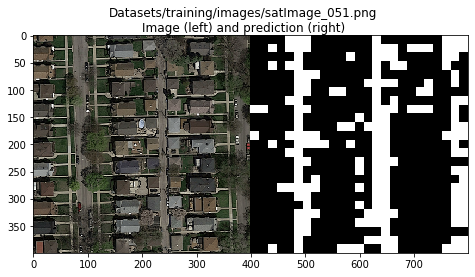

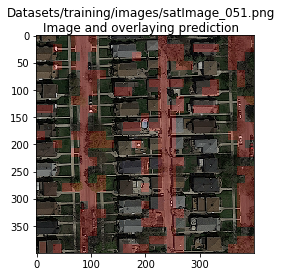

In [102]:
# Model accuracy over the train data

TPR = TruePositiveRate(tX, Y, logreg_final)
print('True positive rate = ' + str(TPR))

# Visualizing the prediction of the img_idx-th image
img_idx = 9
img_path = imagedir + files[img_idx]

VisualizePrediction(logreg_final, degree, img_path)

### 8) Post-processing
To Do...

In [106]:
def PostProcessing(predicted_mask):
    """ Post-processing of the predicted mask"""
    #TODO
    return predicted_mask

### 9) Prediction on the test data and creation of the submission file

In [107]:
def CreateSubmission(logregModel, degree, test_rootdir, test_files, patch_size=16, subdir="Submissions/", preddir="Predictions/"):
    """ Create a submission file using the trained logregModel."""
    prediction_filenames = []
    
    # Prediction of all the test images
    for i  in range(len(test_files)):
        # Image path of the i-th image
        img_path = test_rootdir + test_files[i] + "/" + test_files[i] + ".png"
        
        # Extraction of the data feature
        Xi, img, img_raw = extract_img_features(img_path)
        
        # Data augmentation using polynomial basis
        tXi = build_poly(Xi, degree)
        
        # Prediction of the i-th image using the trained model logregModel
        Yi_pred = logregModel.predict(tXi)
        
        # Construction of the mask
        w = img.shape[0]
        h = img.shape[1]
        predicted_mask = label_to_img(w, h, patch_size, patch_size, Yi_pred)
        
        # Post-processing of the mask: #TODO
        postprocessed_mask = PostProcessing(predicted_mask)
        
        # Creating the name for the predicted mask
        img_id = int(re.search(r"\d+", test_files[i]).group(0))
        prediction_filenames += [preddir + "prediction_" + "%.3d" % img_id + ".png"]
        
        # Saving the masks in the preddir folder
        Image.fromarray(binary_to_uint8(predicted_mask)).save(prediction_filenames[i])  
    
    # Create unique filename
    now = datetime.now()
    dt_string = now.strftime("%H_%M__%d_%m")
    submission_filename = subdir + "submission_" + dt_string + ".csv"
    
    # Create submission
    masks_to_submission(submission_filename, prediction_filenames)

In [108]:
test_rootdir = "Datasets/test_set_images/"
test_files = os.listdir("Datasets/test_set_images/")

CreateSubmission(logreg_final, degree, test_rootdir, test_files) 